This notebook generates the spike raster and firing rate plots. It requires the spiking data recorded from one model run [which needs to be downloaded separately](https://dx.doi.org/10.6084/m9.figshare.3749700.v1) and saved as `spikeplot.npz` in the `../data` folder.

In [1]:
%matplotlib inline

In [2]:
sns.set('paper', 'ticks')

In [3]:
import matplotlib
import numpy
import scipy
import scipy.ndimage

def prepare_spikes(time, data, sample_by_variance=None,
                     sample=None, sample_filter_width=20,
                     cluster=False, cluster_filter_width=2,
                     merge=None, contrast_scale=1.0, yticks=None,
                     sample_index=None, cluster_index=None):

    if sample_index:
        data = data[:, sample_index]    
    elif sample_by_variance is not None and sample_by_variance<len(data.T):
        dd=scipy.ndimage.gaussian_filter1d(data.astype(float).T,sample_filter_width,axis=1)
        vard=numpy.var(dd,axis=1)

        threshold=sorted(vard)[-sample_by_variance]                        
        index=[k for k,v in enumerate(vard) if v>=threshold]
        data=data[:,index]

    if sample is not None and sample<len(data.T):    
        stepsize=float(len(data.T))/sample
        data2=[]
        for k in range(sample):
            sub=data[:,int(k*stepsize):int((k+1)*stepsize)]
            count=numpy.sum(sub,axis=0)
            data2.append(sub[:, numpy.argmax(count)])
        data=numpy.array(data2).T    

    if cluster_index:
        data = data[:, cluster_index]    
    elif cluster:
        dd=scipy.ndimage.gaussian_filter1d(data.astype(float).T,cluster_filter_width,axis=1)
        z=scipy.cluster.hierarchy.linkage(dd)
        tree=scipy.cluster.hierarchy.to_tree(z)
        order=tree.pre_order()
        data=data[:,order]
    if merge is not None and merge<len(data.T):    
        stepsize=float(len(data.T))/merge
        data2=[]
        for k in range(merge):
            v=numpy.sum(data[:,int(k*stepsize):int((k+1)*stepsize)],axis=1)
            data2.append(v)
        data=numpy.array(data2).T    
    return data, time
               
def add_spikes(ax, data, time, contrast_scale=1.0):
    imgplt=ax.imshow(data.T,aspect='auto',cmap=matplotlib.cm.gray_r,interpolation='nearest',extent=(time[0],time[-1],0,len(data.T)))
    imgplt.set_clim(0.0,numpy.max(data)*contrast_scale)
    


In [4]:
data = np.load('../data/spikeplot.npz')

data.keys()

['cue_spikes',
 'switch_spikes',
 'response_spikes',
 'cue',
 'trange',
 'vocab_vectors',
 'switch',
 'vocab_keys',
 'response']

In [5]:
spikes_switch = prepare_spikes(data['trange'], data['switch_spikes'])

In [6]:
spikes_response = prepare_spikes(
    data['trange'], data['response_spikes'],
    sample_by_variance=400, sample_filter_width=50, merge=50, cluster=True)

In [7]:
vocab = spa.Vocabulary(data['vocab_vectors'].shape[1])
for k, v in zip(data['vocab_keys'], data['vocab_vectors']):
    vocab.add(k.decode('ascii'), spa.SemanticPointer(v))
cue_vocab = vocab.create_subset(['WIDOW', 'BITE', 'MONKEY'])

In [8]:
from matplotlib import gridspec

In [9]:
spikes_cue = prepare_spikes(
    data['trange'], data['cue_spikes'],
    sample_by_variance=400, sample_filter_width=100, merge=50, cluster=True)

In [10]:
response_timings = [
    0.40100000000000002, 0.51500000000000001, 0.66300000000000003, 0.78900000000000003, 1.1320000000000001, 1.246, 1.3800000000000001, 1.5190000000000001]
responses = ['SAD', 'SPIDER', 'LONELY', 'RIGHT', 'HURT', 'PAIN', 'ALONE', 'MAN']

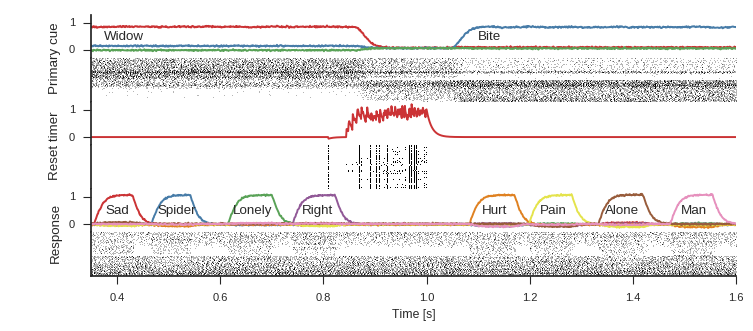

In [12]:
sns.set_palette(sns.color_palette('Set1', n_colors=8, desat=.75))
fig = plt.figure(figsize=(18 / 2.54, 8 / 2.54))

gs = gridspec.GridSpec(6, 2, hspace=0, width_ratios=[.03, .97], wspace=0.09, left=0., right=.98, bottom=.15, top=.98)

def decoded_plot_style(ax):
    sns.despine(ax=ax, bottom=True)
    ax.set_yticks([0, 1])
    ax.set_ylim([-0.3, 1.3])
    ax.tick_params(labelbottom='off', bottom='off')
    
ax = fig.add_subplot(gs[0:2, 0])
ax.axis('off')
ax.text(1.0, .5, 'Primary cue', {'ha': 'right', 'va': 'center'}, rotation=90)
ax = fig.add_subplot(gs[2:4, 0])
ax.axis('off')
ax.text(1.0, .5, 'Reset timer', {'ha': 'right', 'va': 'center'}, rotation=90)
ax = fig.add_subplot(gs[4:6, 0])
ax.axis('off')
ax.text(1.0, .5, 'Response', {'ha': 'right', 'va': 'center'}, rotation=90)


ax = fig.add_subplot(gs[0, 1])
ax.plot(data['trange'], spa.similarity(data['cue'], cue_vocab))
ax.text(0.375, 0.5, 'Widow', {'ha': 'left', 'va': 'center'})
ax.text(1.1, 0.5, 'Bite', {'ha': 'left', 'va': 'center'})
decoded_plot_style(ax)

ax = fig.add_subplot(gs[1, 1], sharex=ax)
add_spikes(ax, *spikes_cue, contrast_scale=0.5)
sns.despine(ax=ax, bottom=True)
ax.tick_params(labelbottom='off', labelleft='off', bottom='off')
ax.set_yticks([])

ax = fig.add_subplot(gs[2, 1], sharex=ax)
ax.plot(data['trange'], data['switch'])
decoded_plot_style(ax)

ax = fig.add_subplot(gs[3, 1], sharex=ax)
add_spikes(ax, *spikes_switch, contrast_scale=.5)
sns.despine(ax=ax, bottom=True)
ax.tick_params(labelbottom='off', labelleft='off', bottom='off')
ax.set_yticks([])

ax = fig.add_subplot(gs[4, 1], sharex=ax)
ax.plot(data['trange'], spa.similarity(data['response'], vocab.create_subset(responses)))
for t, x in zip(response_timings, responses):
    label = x[0] + x[1:].lower()
    ax.text(t, 0.5, label, {'ha': 'center', 'va': 'center'})
decoded_plot_style(ax)

ax = fig.add_subplot(gs[5, 1], sharex=ax)
add_spikes(ax, *spikes_response, contrast_scale=.5)
sns.despine(ax=ax)
ax.tick_params(labelleft='off')
ax.set_yticks([])

ax.set_xlim(0.35, 1.6)
ax.set_xlabel("Time [s]")

# Individual cell firing rates

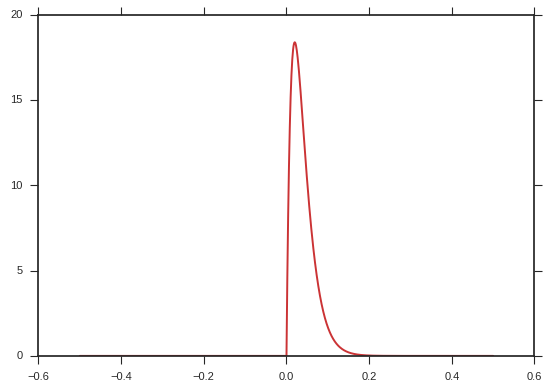

In [13]:
dt = 0.001
shifts = np.arange(-.5, .5 + dt, dt)
alpha = 50.
filt = np.maximum(0, alpha**2 * shifts * np.exp(-alpha * shifts))
plt.plot(shifts, filt)

In [14]:
def filt_spike_train(data, index):
    return np.convolve(data[:, index] * dt, filt, 'same')

widow_train = filt_spike_train(data['cue_spikes'], 2817)
bite_train = filt_spike_train(data['cue_spikes'], 6210)
both_train = filt_spike_train(data['cue_spikes'], 1933)
similar_train = filt_spike_train(data['cue_spikes'], 7)
response_train = filt_spike_train(data['response_spikes'], 7900)

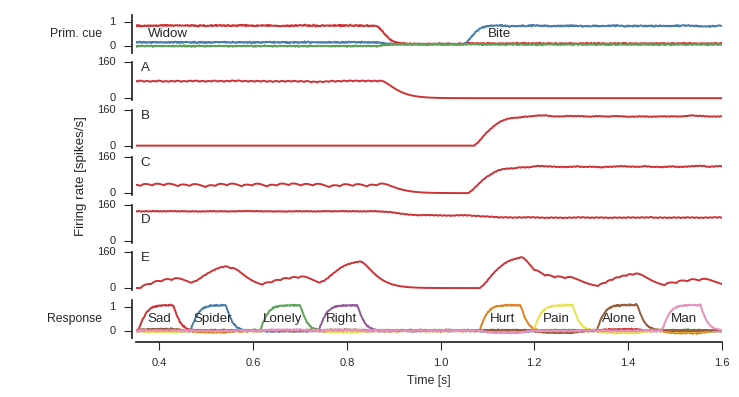

In [15]:
fig = plt.figure(figsize=(18 / 2.54, 10 / 2.54))
offset = 3

gs = gridspec.GridSpec(7, 2, hspace=0.25, width_ratios=[.1, .9], wspace=0.09, left=0.01, right=.97, bottom=.16, top=.98)

ax = fig.add_subplot(gs[:, 0])
ax.axis('off')
ax.text(0.7, .5, 'Firing rate [spikes/s]', {'ha': 'right', 'va': 'center'}, rotation=90)

ax = fig.add_subplot(gs[0, 1])
ax.plot(data['trange'], spa.similarity(data['cue'], cue_vocab))
ax.text(0.375, 0.5, 'Widow', {'ha': 'left', 'va': 'center'})
ax.text(1.1, 0.5, 'Bite', {'ha': 'left', 'va': 'center'})
decoded_plot_style(ax)
sns.despine(ax=ax, offset=offset, bottom=True)
ax.tick_params(labelbottom='off', bottom='off')
ax.set_ylabel("Prim. cue", rotation=0, ha='right', va='center')

ax = fig.add_subplot(gs[1, 1], sharex=ax)
ax.plot(data['trange'], widow_train)
sns.despine(ax=ax, offset=offset, bottom=True)
ax.tick_params(labelbottom='off', bottom='off')
ax.text(.36, 160.0, 'A', {'ha': 'left', 'va': 'top'})

ax = fig.add_subplot(gs[2, 1], sharex=ax, sharey=ax)
ax.plot(data['trange'], bite_train)
sns.despine(ax=ax, offset=offset, bottom=True)
ax.tick_params(labelbottom='off', bottom='off')
ax.text(.36, 160.0, 'B', {'ha': 'left', 'va': 'top'})

ax = fig.add_subplot(gs[3, 1], sharex=ax, sharey=ax)
ax.plot(data['trange'], both_train)
sns.despine(ax=ax, offset=offset, bottom=True)
ax.tick_params(labelbottom='off', bottom='off')
ax.text(.36, 160.0, 'C', {'ha': 'left', 'va': 'top'})

ax = fig.add_subplot(gs[4, 1], sharex=ax, sharey=ax)
ax.plot(data['trange'], similar_train)
sns.despine(ax=ax, offset=offset, bottom=True)
ax.tick_params(labelbottom='off', bottom='off')
ax.text(.36, 120.0, 'D', {'ha': 'left', 'va': 'top'})

ax = fig.add_subplot(gs[5, 1], sharex=ax, sharey=ax)
ax.plot(data['trange'], response_train)
sns.despine(ax=ax, offset=offset, bottom=True)
ax.tick_params(labelbottom='off', bottom='off')
ax.text(.36, 160.0, 'E', {'ha': 'left', 'va': 'top'})

ax.set_ylim(-10, 160)
ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator([0, 160]))

ax = fig.add_subplot(gs[6, 1], sharex=ax)
ax.plot(data['trange'], spa.similarity(data['response'], vocab.create_subset(responses)))
for t, x in zip(response_timings, responses):
    label = x[0] + x[1:].lower()
    ax.text(t, 0.5, label, {'ha': 'center', 'va': 'center'})
decoded_plot_style(ax)
sns.despine(ax=ax, offset=offset)
ax.set_ylabel("Response", rotation=0, ha='right', va='center')

ax.set_xlim(0.35, 1.6)
ax.set_xlabel("Time [s]")